# AlexNet Attempt

## Data Loading

In [ ]:
# Importing the libraries
import os
import torch
from helper import *

In [ ]:
data_dir = "dataset"   # The name of the folder containing the dataset within the current working directory

# remove ds_store file that mac creates
if os.path.exists(data_dir + "/.DS_Store"):
    os.remove(data_dir + "/.DS_Store")

print(os.listdir(data_dir)) # List the first level of files (folders in this instance) in the dataset folder for verification

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [ ]:
# Optional verification for all files in the dataset folder
from os import walk
for (dirpath, dirnames, filenames) in walk(data_dir):
    print("Directory path: ", dirpath)
    #print("File name: ", filenames)

Directory path:  dataset
Folder name:  ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Directory path:  dataset\cataract
Folder name:  []
Directory path:  dataset\diabetic_retinopathy
Folder name:  []
Directory path:  dataset\glaucoma
Folder name:  []
Directory path:  dataset\normal
Folder name:  []


## Pre-Processing

Defining preprocessing variables for the dataset

- img_size converts all images to be of size 227x227 as the input size of AlexNet is specifically 227x227 pixels

- Using a BATCH_SIZE = 32 as it strikes a balance between offering a moderately stable gradient estimate and not consuming excessive memory.

In [ ]:
img_size = 227 
BATCH_SIZE = 32 

Begin preprocessing steps. 
We are applying a resize to 277x227 pixels, croping the image around the center, converting the image to a tensor and, normalising the image. These steps standardize the data, making it more uniform and better suited for training, which helps the model learn effectively and improves performance

In [ ]:
from torchvision import transforms # using the torchvision library for image transformations

# Attempting to make images more uniform for improved training
def transform(image_size: int):
    transform = transforms.Compose([
        transforms.Resize(image_size), # Resize the image to 227x227 pixels
        transforms.CenterCrop(image_size), # Crop the image about the center
        transforms.ToTensor(), # Convert the image to a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image.
    ])
    return transform


In [ ]:
from torchvision import datasets # Importing the datasets module from torchvision
dataset = datasets.ImageFolder(data_dir, transform=transform(img_size)) # Loading the dataset from the folder
dataset.class_to_idx # Displaying the classes and their respective indices

{'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}

Here we split into training and testing datasets (80% training, 20% testing) and create the data loaders for the training and testing datasets 

Shuffle is used to randomize the data to prevent the model from learning the order 
Batch size is used to specify the number of samples to be used in each iteration.

In [ ]:

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2]) 

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)  

<Axes: >

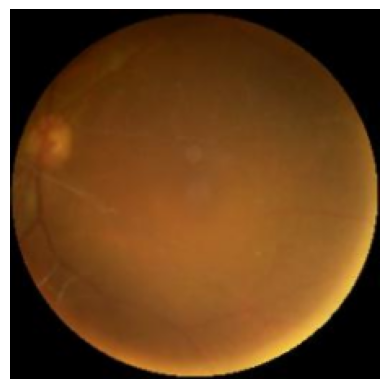

In [ ]:
# Display example image from the train loader to verify the data
images, labels = next(iter(train_loader))
imshow(images[0])

## AlexNet Training

The problem we are trying to solve is an image classification problem. Specifically, we are classifying images into distinct categories where each image belongs to one class. Images can belong to the classes ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

The goal is to train a model that can accurately predict the correct class for new, unseen images.

AlexNet was chosen as the model due to the number of images being used and presence of hardware limitations requiring a model that can trains efficiently over a smaller duration. Through analysis and comparission with other methods and models we discovered that AlexNet's accuracy for this task was effective while remaining speedy and thus decided on this approach for our final model. 

In [ ]:
# Importing the necessary libraries for the model
from heading import *
import torch

Defining the model parameters

- We chose input_channels as 3 because the images are colored images and have 3 channels (RGB) 
- The output_size is 4 because we have 4 classes in the dataset
- Epoch is the number of times the model goes through the entire dataset and was an experimentally chosen value based on the model's performance
- LR is the learning rate and was also an experimentally chosen value based on the model's performance
- number_of_images is the number of images to use from the dataset and was chosen to be 2000 to reduce the training time while still maintaining a good model performance

In [ ]:

input_channels = 3
output_size = 4

EPOCH = 80
LR = 0.001
number_of_images = 2000

Next, we create the model using the AlexNet architecture and the create_network function from the heading.py file

In [ ]:

Alex_net = AlexNet(input_channels, output_size)
alex_net = create_network(Alex_net)

In [ ]:
# Manually verifiying if CUDA is available to be used for faster training

print(torch.cuda.is_available())  # This will return False if CUDA isn't supported
print(torch.__version__)  # Check the PyTorch version

True
2.5.1+cu121


Finally we train are model using the train_model function provided in heading.py. We provide all parameters as mentioned above. 
- Note that this function includes a learning rate scheduler that proides decay every 20 epochs by a factor of 0.5 as this was discovered to help the model converge more effectively as we increased epoch count

In [ ]:
trained_alexnet_model = train_model(alex_net, train_loader, LR, EPOCH, number_of_images)

Epoch 1/80, Avg Loss: 1.4434, LR: 0.001000
Epoch 2/80, Avg Loss: 1.2438, LR: 0.001000
Epoch 3/80, Avg Loss: 1.0037, LR: 0.001000
Epoch 4/80, Avg Loss: 0.9132, LR: 0.001000
Epoch 5/80, Avg Loss: 0.8531, LR: 0.001000
Epoch 6/80, Avg Loss: 0.6796, LR: 0.001000
Epoch 7/80, Avg Loss: 0.6329, LR: 0.001000
Epoch 8/80, Avg Loss: 0.6334, LR: 0.001000
Epoch 9/80, Avg Loss: 0.6203, LR: 0.001000
Epoch 10/80, Avg Loss: 0.5735, LR: 0.001000
Epoch 11/80, Avg Loss: 0.5565, LR: 0.001000
Epoch 12/80, Avg Loss: 0.5058, LR: 0.001000
Epoch 13/80, Avg Loss: 0.5474, LR: 0.001000
Epoch 14/80, Avg Loss: 0.4996, LR: 0.001000
Epoch 15/80, Avg Loss: 0.5070, LR: 0.001000
Epoch 16/80, Avg Loss: 0.5591, LR: 0.001000
Epoch 17/80, Avg Loss: 0.5399, LR: 0.001000
Epoch 18/80, Avg Loss: 0.4875, LR: 0.001000
Epoch 19/80, Avg Loss: 0.4813, LR: 0.001000
Epoch 20/80, Avg Loss: 0.4680, LR: 0.000500
Epoch 21/80, Avg Loss: 0.3737, LR: 0.000500
Epoch 22/80, Avg Loss: 0.3496, LR: 0.000500
Epoch 23/80, Avg Loss: 0.3302, LR: 0.0005

Next, we run the test function to evaluate the model on the test dataset. We provide the param of 300 images to be used for this testing process

In [34]:
test_model(trained_alexnet_model, test_loader, number_of_images = 300)

Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Correct predictions: 253
Test accuracy: 0.8433


Next, we ask the model to make a prediction on a given image 
- It will predict the class of a given image. For this example we used the first image in the test dataset
- Prediciton function takes in the model, the image and the label list

In [ ]:
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# Retrieve and display the first image from the dataset
first_image, _ = test_dataset[0]

select_image = first_image 
label_list = dataset.class_to_idx

# Uncomment to use predict_image
predict_image(trained_alexnet_model, select_image, label_list)

Predicted result(s): ['normal']
Confidence: tensor([1.0000], device='cuda:0', grad_fn=<IndexBackward0>)


Next, we save the model such that it can be used at a later date without training it up again. It is saved to the current working director under the given name 'AlexNet_model.pth'

In [ ]:
torch.save(trained_alexnet_model, 'AlexNet_model.pth')

## AlexNet Retraining

Optional retraining for further increasing model performance. 

Here we change the training params as required to suit our retraining purposes

In [ ]:
LR = 0.0005 # We reduce the learning rate to 0.0005
EPOCH = 20 # We reduce the number of epochs to 20

In [ ]:
pretrained_alexnet_model = torch.load('AlexNet_model.pth') # Load model from the saved file name
pre_trained_alexnet_model = train_model(pretrained_alexnet_model, train_loader, LR, EPOCH, number_of_images) # Additional training on this model

C:\Users\wells\AppData\Local\Temp\ipykernel_17980\377103270.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_alexnet_model = torch.load('AlexNet_model.pth')


Epoch 1/80, Avg Loss: 0.2674, LR: 0.001000


KeyboardInterrupt: 

Now, we can do more testing on our retrained model, and we can also save this new model if we like by uncommenting the last line

In [ ]:
test_model(pre_trained_alexnet_model, test_loader, number_of_images = 100) # Test the model on 100 images from the test dataset

#torch.save(pre_trained_alexnet_model, 'AlexNet_model1.pth') # Save the model to a new file name

Batch 1
Batch 2
Batch 3
Batch 4
Correct predictions: 83
Test accuracy: 0.8300
